In [152]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [153]:
matplotlib.rcParams.update({'font.size': 12})

In [154]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [155]:
# Изменение типа столбцов в dataframe -- функция
def to_Str(df_, list):
    for i in list:
        df_[i] = df_[i].astype(str)
        
# создаем из категориальных столбцов с двумя значениями boolean столбец и меняем ему тип на int
def AB_to_NewIntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df[i+'_'] = df[i+'_'].astype(int)
        
# у категориальных столбцов с двумя значениями меняем тип на int
def AB_to_IntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df_[i+'_'] = df_[i+'_'].astype(int)
        df_[i] = df_[i+'_']
#         df_ = df_.drop([i+'_'],axis=1)
# Обработка пропусков -- функции
def get_NaN_info(df_):
    return len(df_)-df_.count()

def set_NaN_median(df_, col1):
    df_.loc[df_[col1].isnull(), col1] = df_[col1].median()
def features_Stand(features_,X_):
    scaler = StandardScaler()
    X_train_scaled = X_.copy()
    X_train_scaled[features_] = scaler.fit_transform(X_train_scaled[features_])
    return X_train_scaled
# Обработка выбросов -- медианы для значений за пределами 
def IQ_param_get(df_, column_):
    m = df_[column_].median()
    c = column_
    IQ=df_[c].describe()['75%']-df_[c].describe()['25%']
    
    low_border=df_[c].describe()['25%']-IQ*1.5
    
    high_border=df_[c].describe()['75%']+IQ*1.5
 
    count1 = df_[(df_[c] < low_border) | (df_[c]> high_border)][c].count()
    
    result = {
        'IQ':IQ,
        'low_border':low_border,
        'high_border':high_border,
        'count': count1,
        'median': m
    }
    return result

In [156]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [157]:
# интерквартильный размах
def IQ_processing(df_, list_):
    for i in list_:
        c = i
        IQP = IQ_param_get(df_,c)
        print(c,IQP)
        df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])]
        df_.loc[df_[c] > IQP['high_border'], c] = IQP['median']
        df_.loc[df_[c] < IQP['low_border'], c] = IQP['median']
        print('count after procesing:',df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])][c].count())

In [158]:
def draw_feature(fname):
    t = fname
    plt.figure(figsize = (12, 6))

    train[t].hist(bins=16)
    test[t].hist(bins=16)
    plt.ylabel('count')
    plt.xlabel(t)

    plt.title('Distribution of '+ t +' value in TRAINING and TEST dataset')
    plt.show()

In [159]:
def HouseFloor_processing(df_):
    Fmode = df_['Floor'].mode()[0]
    HFmode = df_['HouseFloor'].mode()[0]
    print('Floor:',Fmode,'HouseFloor:',HFmode)

    df_.loc[(df_['HouseFloor']==0) & (HFmode >= df_['Floor']),'HouseFloor'] = HFmode #if HFmode > df_['Floor'] else df_['Floor']
    df_.loc[(df_['HouseFloor']==0) & (HFmode < df_['Floor']),'HouseFloor'] = df_['Floor']

    df_.loc[(df_['HouseFloor'] < df_['Floor'])&(HFmode >= df_['Floor']), 'HouseFloor'] = HFmode
    df_.loc[(df_['HouseFloor'] < df_['Floor'])&(HFmode < df_['Floor']), 'HouseFloor'] = df_['Floor']

In [160]:
def SAVE_TO_FILE(df_, modelName):
    df_.loc[:, ['Id', 'Price']].to_csv('m_khaskin_kaggle_predictions(' + modelName + ').csv', index=False)

In [161]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

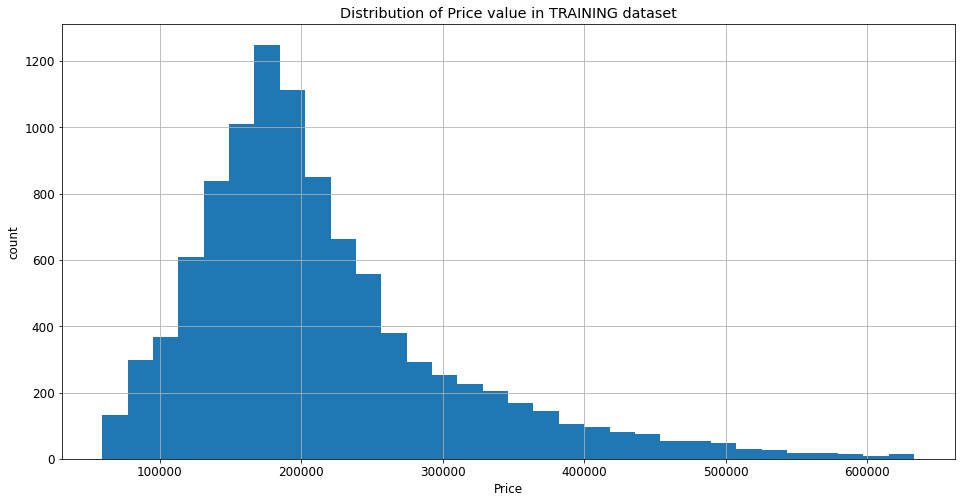

In [162]:
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=32)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price value in TRAINING dataset')
plt.show()

In [163]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [164]:
test['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [165]:
to_Str(train,['Id','DistrictId'])
to_Str(test,['Id','DistrictId'])
#to_Str(train,['Id'])
#to_Str(test,['Id'])
test.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [166]:
set_NaN_median(test,'LifeSquare')
set_NaN_median(test,'Healthcare_1')
get_NaN_info(test)

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [167]:
set_NaN_median(train,'LifeSquare')
set_NaN_median(train,'Healthcare_1')
get_NaN_info(train)

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [168]:
KSmode = train['KitchenSquare'].mode()[0]
LSmode = train['LifeSquare'].mode()[0]
Rmode = train['Rooms'].mode()[0]
print('MODE values in train are:')
print('KitchenSquare:',KSmode,'LifeSquare:',LSmode,'Rooms:',Rmode)

train.loc[train['Rooms']==0, 'Rooms'] = Rmode
train.loc[train['KitchenSquare']==0, 'KitchenSquare'] = KSmode

#train[(train['Rooms']==0) | (train['KitchenSquare']==0)]

MODE values in train are:
KitchenSquare: 1.0 LifeSquare: 32.78126019215574 Rooms: 2.0


In [169]:
train['Rooms'].value_counts()

2.0     3888
1.0     3705
3.0     2235
4.0      150
5.0       18
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [170]:
KSmode = test['KitchenSquare'].mode()[0]
LSmode = test['LifeSquare'].mode()[0]
Rmode = test['Rooms'].mode()[0]
print('MODE values in test are:')
print('KitchenSquare:',KSmode,'LifeSquare:',LSmode,'Rooms:',Rmode)

test.loc[test['Rooms']==0, 'Rooms'] = Rmode
test.loc[test['KitchenSquare']==0, 'KitchenSquare'] = KSmode

# test[(test['Rooms']==0) | (test['KitchenSquare']==0)]

MODE values in test are:
KitchenSquare: 1.0 LifeSquare: 32.92508663208161 Rooms: 2.0


In [171]:
test['Rooms'].value_counts
#test['KitchenSquare'].value_counts()

<bound method IndexOpsMixin.value_counts of 0       2.0
1       2.0
2       1.0
3       2.0
4       1.0
       ... 
4995    3.0
4996    1.0
4997    3.0
4998    2.0
4999    2.0
Name: Rooms, Length: 5000, dtype: float64>

In [172]:
# AB_to_NewIntColumns(df,['Ecology_2','Ecology_3','Shops_2'],'A')
# AB_to_IntColumns(df,['Ecology_2','Ecology_3','Shops_2'],'A')
AB_to_IntColumns(test,['Ecology_2','Ecology_3','Shops_2'],'A')
AB_to_IntColumns(train,['Ecology_2','Ecology_3','Shops_2'],'A')
test['Shops_2'].value_counts()

0    4588
1     412
Name: Shops_2, dtype: int64

In [173]:
train = train.drop(['Ecology_2_'],axis=1)
train = train.drop(['Ecology_3_'],axis=1)
train = train.drop(['Shops_2_'],axis=1)
test = test.drop(['Ecology_2_'],axis=1)
test = test.drop(['Ecology_3_'],axis=1)
test = test.drop(['Shops_2_'],axis=1)

test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.910800,56.449500,35.485549,6.043800,8.632000,12.601000,1984.392600,0.119874,0.009600,0.029800,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.082400
std,0.837725,19.092787,15.915345,9.912837,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001
min,1.000000,1.378543,0.333490,1.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,0.000000,0.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.000000
75%,2.000000,66.285129,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,0.000000,0.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


Выбросы:

In [174]:
# интерквартильный размах
list = ['LifeSquare','Square', 'KitchenSquare']
list=['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseYear', 'Social_1', 'Social_2', 'Helthcare_2'] #RF 0.73303
list=['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
print('processing dataframe train')
IQ_processing(train, list)
print('processing dataframe test')
IQ_processing(test, list)

processing dataframe train
Square {'IQ': 24.125744426186976, 'low_border': 5.586264180189367, 'high_border': 102.08924188493728, 'count': 242, 'median': 52.51330992401352}
count after procesing: 0
LifeSquare {'IQ': 15.899834993080137, 'low_border': 1.6776461714428557, 'high_border': 65.27698614376341, 'count': 517, 'median': 32.78126019215574}
count after procesing: 0
KitchenSquare {'IQ': 8.0, 'low_border': -11.0, 'high_border': 21.0, 'count': 47, 'median': 6.0}
count after procesing: 0
Floor {'IQ': 8.0, 'low_border': -8.0, 'high_border': 24.0, 'count': 66, 'median': 7.0}
count after procesing: 0
HouseFloor {'IQ': 8.0, 'low_border': -3.0, 'high_border': 29.0, 'count': 49, 'median': 13.0}
count after procesing: 0
HouseYear {'IQ': 27.0, 'low_border': 1933.5, 'high_border': 2041.5, 'count': 38, 'median': 1977.0}
count after procesing: 0
Ecology_1 {'IQ': 0.17813400000000001, 'low_border': -0.24955394700000003, 'high_border': 0.46298205300000006, 'count': 61, 'median': 0.07542368}
count aft

In [175]:
train.loc[train['LifeSquare']>train['Square'], 'LifeSquare'] = train['Square'] - train['KitchenSquare']
train[train['LifeSquare']>train['Square']]

test.loc[test['LifeSquare']>test['Square'], 'LifeSquare'] = test['Square'] - test['KitchenSquare']
test[test['LifeSquare']>test['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [176]:
#Год постройки train
mode = train['HouseYear'].mode()[0]
print('mode', mode)
train.loc[train['HouseYear'] > 2019, 'HouseYear'] = mode
train['HouseYear'] = train['HouseYear'].astype(int)
train['HouseYear'].nlargest()

mode 1977


257    2019
372    2019
400    2019
518    2019
534    2019
Name: HouseYear, dtype: int32

In [177]:
#Год постройки test
test.loc[test['HouseYear'] > 2019, 'HouseYear'] = test['HouseYear'].mode()[0]
test['HouseYear'] = test['HouseYear'].astype(int)
test['HouseYear'].nlargest()

61     2019
122    2019
422    2019
775    2019
847    2019
Name: HouseYear, dtype: int32

In [178]:
m=train['KitchenSquare'].mean()
print('KitchenSquare mean value in TRAIN is:',m)
train.loc[train['KitchenSquare'] < 4, 'KitchenSquare'] = m
# test.loc[test['HouseYear'] > 2019, 'HouseYear'] = test['HouseYear'].mode()[0]

m=test['KitchenSquare'].mean()
print('KitchenSquare mean value in TEST is:',m)
test.loc[test['KitchenSquare'] < 4, 'KitchenSquare'] = m
# test[test['KitchenSquare'] < 4]

KitchenSquare mean value in TRAIN is: 5.7469
KitchenSquare mean value in TEST is: 5.761


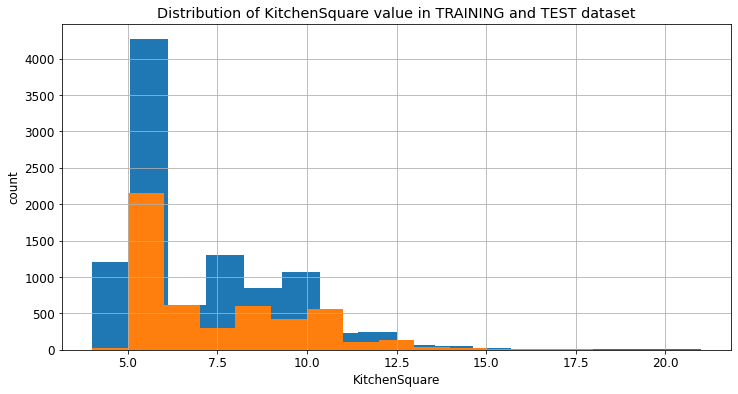

In [179]:
# train['KitchenSquare'].value_counts()
draw_feature('KitchenSquare')

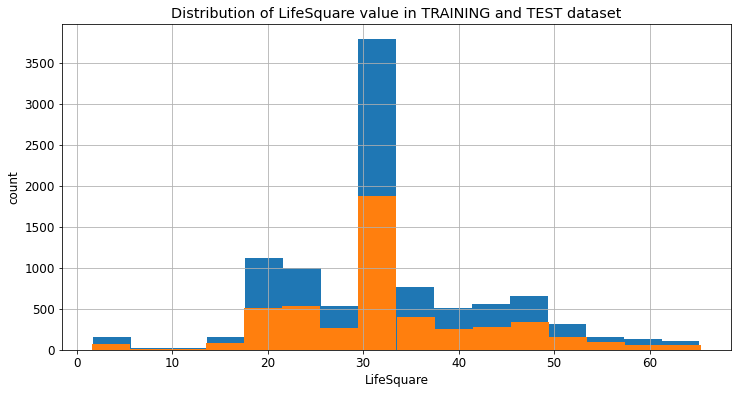

In [180]:
# train['KitchenSquare'].value_counts()
draw_feature('LifeSquare')

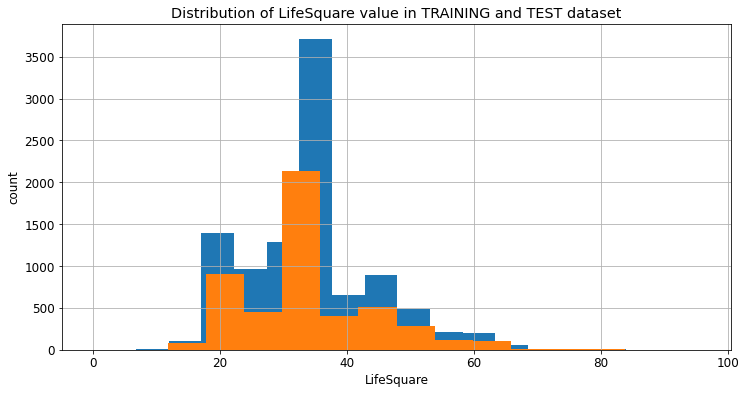

In [181]:
train.loc[train['LifeSquare'] < 15, 'LifeSquare'] = train['Square'] - train['KitchenSquare']
test.loc[test['LifeSquare'] < 15, 'LifeSquare'] = test['Square'] - test['KitchenSquare']
draw_feature('LifeSquare')

In [182]:
print('Processing HouseFloor in TRAIN')
HouseFloor_processing(train)
print('Processing HouseFloor in TEST')
HouseFloor_processing(test)

Processing HouseFloor in TRAIN
Floor: 4 HouseFloor: 17.0
Processing HouseFloor in TEST
Floor: 4 HouseFloor: 17.0


In [183]:
train[train['HouseFloor'] < train['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [184]:
df = train
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.892100,54.654781,33.702655,7.253038,8.398500,14.545200,1984.970900,0.116213,0.009700,0.027500,24.687000,5109.312600,2.378400,904.909000,1.270000,3.343800,0.082500,214138.857399
std,0.837811,15.859586,10.231962,2.214583,5.029714,5.200814,17.989064,0.115070,0.098015,0.163543,17.532614,3560.474465,2.652078,70.412835,1.418627,3.083172,0.275139,92872.293865
min,1.000000,13.784865,6.784865,4.000000,1.000000,1.000000,1934.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,620.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.794392,27.596772,5.746900,4.000000,10.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,900.000000,0.000000,1.000000,0.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,17.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,192269.644879
75%,2.000000,64.682943,37.939703,9.000000,12.000000,17.000000,2001.000000,0.194489,0.000000,0.000000,36.000000,7065.000000,4.000000,900.000000,2.000000,5.000000,0.000000,249135.462171
max,19.000000,102.056968,89.141693,21.000000,24.000000,29.000000,2019.000000,0.460556,1.000000,1.000000,74.000000,14892.000000,11.000000,1183.000000,5.000000,11.000000,1.000000,633233.466570


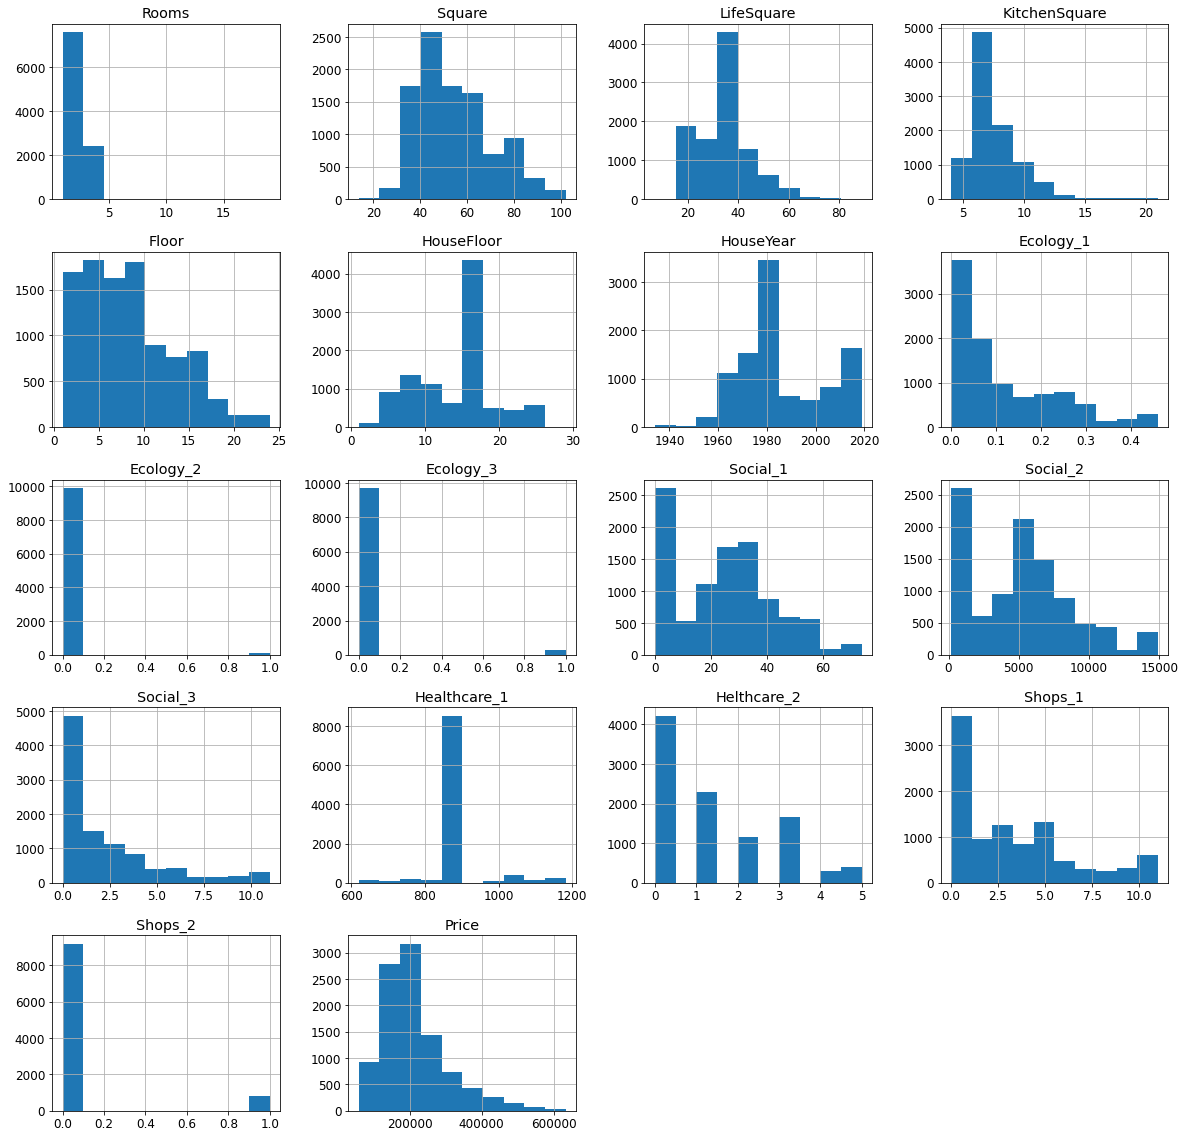

In [185]:
df_num_features = df.select_dtypes(include=['float64', 'int'])
df_num_features.hist(figsize=(20,20), bins=10, grid=True);

In [186]:
#Стандартизация

feature_names = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Shops_2']

feature_names_without_id = feature_names.copy()
feature_names_without_id.remove('Id')
Xtrain = train[feature_names]
Xtest = test[feature_names]

feature_names_for_stand = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']

X2train = features_Stand(feature_names_for_stand, Xtrain)
X2train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,2.241762e-16,-6.505907e-18,-1.955769e-16,1.660450e-16,3.352874e-16,-3.370082e-17,-1.191602e-16,-1.893008e-15,1.124212e-16,0.009700,0.027500,-9.445500e-17,-3.573669e-17,4.458434e-16,7.735701e-16,4.797718e-16,9.079404e-17,0.082500
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.098015,0.163543,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.275139
min,-1.156369e+00,-1.064851e+00,-2.577114e+00,-2.630887e+00,-1.468991e+00,-1.471032e+00,-2.604569e+00,-2.833580e+00,-1.009981e+00,0.000000,0.000000,-1.408132e+00,-1.387894e+00,-8.968511e-01,-4.046467e+00,-8.952769e-01,-1.084587e+00,0.000000
25%,-6.974994e-01,-1.064851e+00,-8.109311e-01,-5.967760e-01,-6.801343e-01,-8.745467e-01,-8.739839e-01,-6.098955e-01,-8.566143e-01,0.000000,0.000000,-1.065895e+00,-9.957914e-01,-8.968511e-01,-6.972089e-02,-8.952769e-01,-7.602290e-01,0.000000
50%,-3.304041e-01,1.287944e-01,-1.350337e-01,-9.005519e-02,-5.658407e-01,-2.780615e-01,4.720267e-01,-4.431191e-01,-3.544886e-01,0.000000,0.000000,1.785334e-02,4.934628e-02,-1.426877e-01,-6.972089e-02,-1.903344e-01,-1.115141e-01,0.000000
75%,5.643907e-01,1.287944e-01,6.323409e-01,4.141199e-01,7.888842e-01,7.160804e-01,4.720267e-01,8.910915e-01,6.802878e-01,0.000000,0.000000,6.452869e-01,5.493047e-01,6.114757e-01,-6.972089e-02,5.146080e-01,5.372008e-01,0.000000
max,3.638814e+00,2.042077e+01,2.989016e+00,5.418493e+00,6.207784e+00,3.102021e+00,2.779473e+00,1.891749e+00,2.992627e+00,1.000000,1.000000,2.812784e+00,2.747717e+00,3.251048e+00,3.949634e+00,2.629435e+00,2.483346e+00,1.000000


In [187]:
X2test = features_Stand(feature_names_for_stand, Xtest)
X2test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,0.152140,0.106489,-0.323362,-0.050723,-0.564509,-0.478562,-0.076711,-0.710678,1.711888,0,0,-0.794834,-0.673982,-0.537301,0.139275,-0.901293,-1.084195,0
1,15856,0.514336,0.106489,0.878560,-0.099655,-0.674813,-0.478562,0.485412,-0.430305,-0.348892,0,0,-1.080052,-1.040116,0.195815,0.139275,-0.901293,-0.443985,0
2,5480,3.140252,-1.087339,-2.573636,-3.118959,2.204637,-1.269377,-1.763081,-0.430305,-1.015060,0,0,0.288994,0.663762,-0.170743,0.139275,2.618284,0.516329,0
3,15664,-0.096869,0.106489,1.113196,1.733073,0.820064,2.684699,1.422284,1.251932,-0.119503,0,0,-0.110311,-0.161506,0.195815,0.139275,1.210453,-0.123881,0
4,14275,-0.549613,-1.087339,-0.469445,0.908713,-0.674813,1.696180,0.485412,1.812678,-0.380726,0,0,-1.308227,-1.265773,-0.537301,0.139275,-0.901293,-1.084195,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,-0.911809,1.300318,0.746509,1.624064,-0.564509,-0.676266,-1.013583,-0.654604,-1.013569,0,0,0.631256,0.231998,-0.903859,0.139275,-0.197378,-0.764090,0
4996,4695,-1.138181,-1.087339,-0.923945,-1.171204,1.281588,0.707661,0.485412,1.812678,-0.952448,0,0,-1.365270,-1.367709,-0.903859,0.139275,-0.901293,-0.764090,0
4997,5783,-0.889172,1.300318,1.410603,1.380496,0.820064,2.882402,1.609658,0.242590,-0.216849,0,0,2.798913,0.034548,-0.170743,0.139275,2.618284,-0.123881,0
4998,4780,0.242689,0.106489,1.625370,-0.099655,-0.674813,-0.873969,0.485412,-0.430305,-0.380726,0,0,-1.308227,-1.265773,-0.537301,0.139275,-0.901293,-1.084195,1


In [188]:
y = train['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X2train.drop(['Id'],axis=1), y, test_size=0.3, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     7000 non-null   float64
 1   Rooms          7000 non-null   float64
 2   Square         7000 non-null   float64
 3   LifeSquare     7000 non-null   float64
 4   KitchenSquare  7000 non-null   float64
 5   Floor          7000 non-null   float64
 6   HouseFloor     7000 non-null   float64
 7   HouseYear      7000 non-null   float64
 8   Ecology_1      7000 non-null   float64
 9   Ecology_2      7000 non-null   int32  
 10  Ecology_3      7000 non-null   int32  
 11  Social_1       7000 non-null   float64
 12  Social_2       7000 non-null   float64
 13  Social_3       7000 non-null   float64
 14  Healthcare_1   7000 non-null   float64
 15  Helthcare_2    7000 non-null   float64
 16  Shops_1        7000 non-null   float64
 17  Shops_2        7000 non-null   int32  
dtypes: fl

In [189]:
#Модели
# Линейная регрессия:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [190]:
y_train

9069     88504.384965
2603    207007.956663
7738    182126.280899
1579    524365.550705
5058    322048.433990
            ...      
5734    150136.610509
5191    328680.869407
5390    255102.406709
860     182236.048759
7270    443365.496451
Name: Price, Length: 7000, dtype: float64

R2:	0.535
MAE:	43038.108
MSE:	4011476584.376


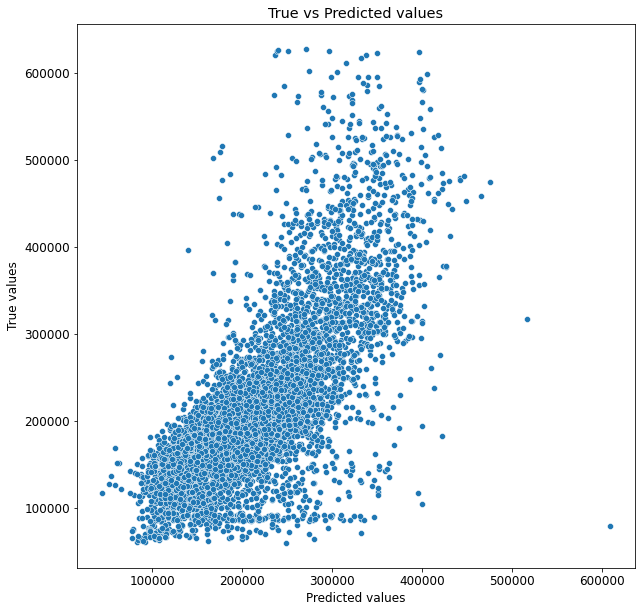

In [191]:
y_train_preds = lr.predict(X_train)
y_train_preds
evaluate_preds(y_train, y_train_preds)

In [192]:
y_valid_preds = lr.predict(X_valid)
y_valid_preds

array([182234.20942116, 280797.78376891, 246669.53238095, ...,
       247786.12314281, 125260.80767519, 254269.27594644])

In [193]:
check_valid = pd.DataFrame({
    "y_valid": y_valid,
    "y_valid_preds": y_valid_preds.flatten(),
})
check_valid["error"] = check_valid["y_valid_preds"] - check_valid["y_valid"]
check_valid

,y_valid,y_valid_preds,error
6252,181530.459031,182234.209421,703.750391
4684,260456.004692,280797.783769,20341.779077
1731,219945.304640,246669.532381,26724.227741
4742,66883.280318,102809.072202,35925.791884
4521,114086.065201,155265.578031,41179.512830
...,...,...,...
8014,139561.798320,118742.800087,-20818.998233
1074,154696.067043,177907.723309,23211.656266
3063,296550.564643,247786.123143,-48764.441500
6487,114949.106711,125260.807675,10311.700964


R2:	0.519
MAE:	43430.798
MSE:	4135728746.708


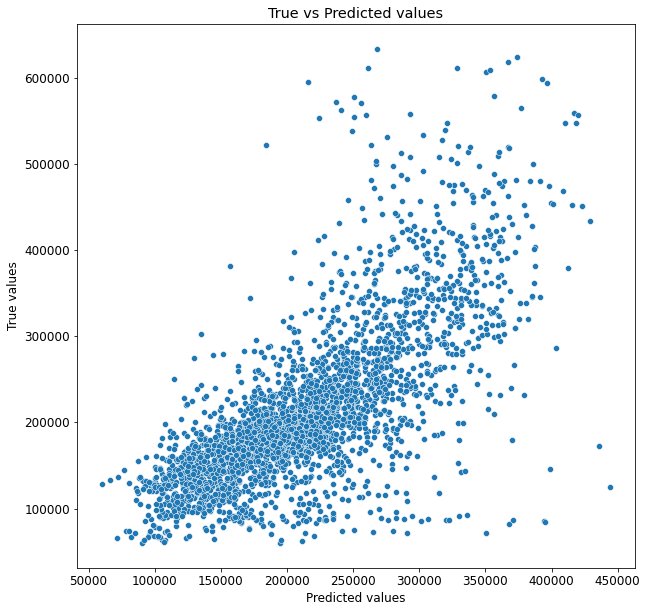

In [194]:
evaluate_preds(y_valid, y_valid_preds)

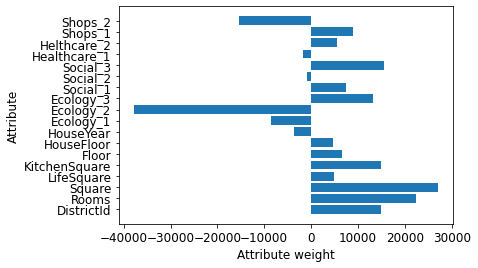

In [195]:
plt.barh(feature_names_without_id, lr.coef_.flatten())

plt.xlabel("Attribute weight")
plt.ylabel("Attribute")

plt.show()

In [196]:
y_test_preds = lr.predict(X2test.drop(['Id'], axis=1))
y_test_preds

array([158380.3715693 , 229120.36567124, 196974.5076886 , ...,
       347024.11972558, 209013.51139779, 222691.04721626])

In [197]:
X2test["Price"] = lr.predict(X2test.drop(['Id'], axis=1))

In [198]:
SAVE_TO_FILE(X2test,'lr')

In [199]:
rs = 22
X_train, X_valid, y_train, y_valid = train_test_split(X2train.drop(['Id'],axis=1), y, test_size=0.10, random_state=rs)
# (n_estimators=1000, max_depth=18, random_state=42, max_features=7)
rf = RandomForestRegressor(n_estimators=1000, max_depth=18, random_state=rs, max_features=7)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features=7, n_estimators=1000,
                      random_state=22)

R2:	0.952
MAE:	12940.431
MSE:	420129567.318


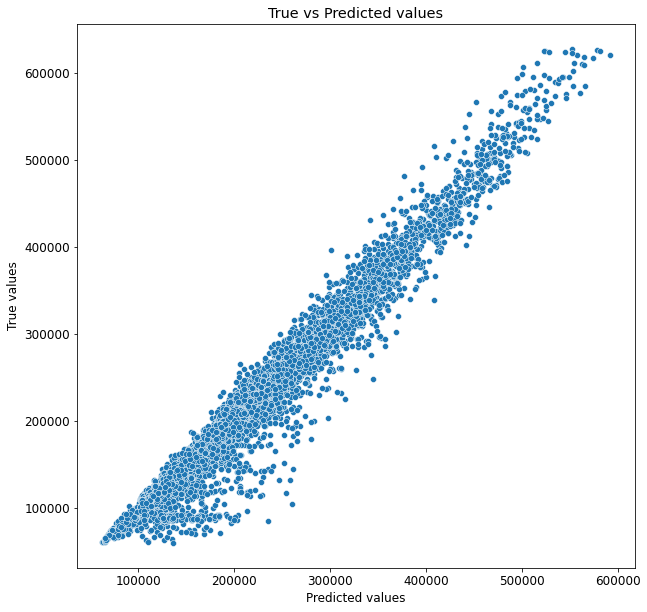

array([295530.44977411, 128073.37082791, 122781.75030556, ...,
       156279.97949667, 279548.54621822, 329738.49950375])

In [200]:
y_train_preds = rf.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_train_preds

R2:	0.736
MAE:	26311.019
MSE:	2059249843.848


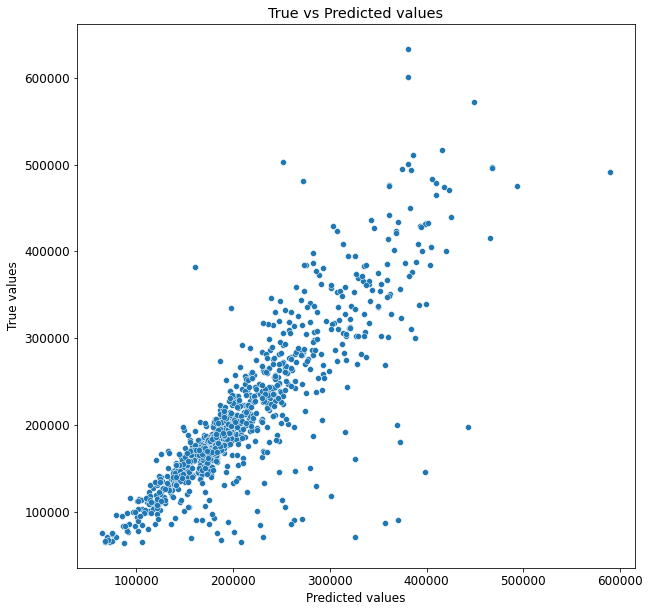

In [201]:
y_valid_preds = rf.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [202]:
df = X2test.drop(['Price'],axis=1).drop(['Id'],axis=1)
X2test['Price'] = rf.predict(df)
SAVE_TO_FILE(X2test,'rf++')